# 计算流体力学 第四次作业
> 2100011025 王奕博
## Q1：
采用 Lax-Wendroff 格式计算 t = 1 时的结果。

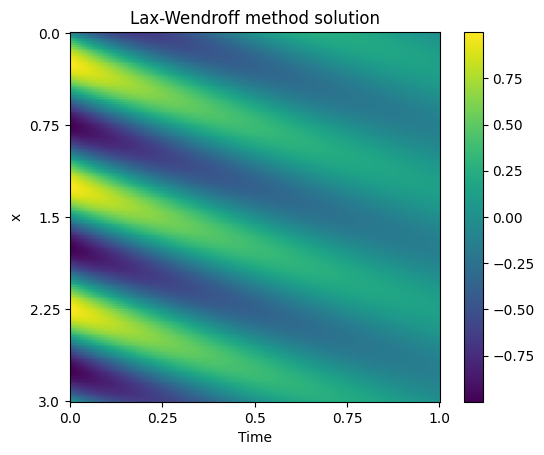

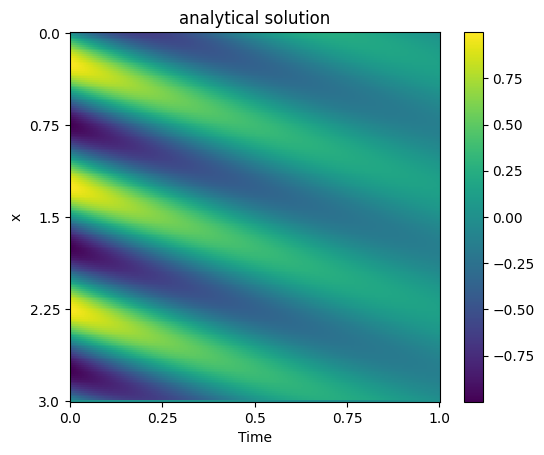

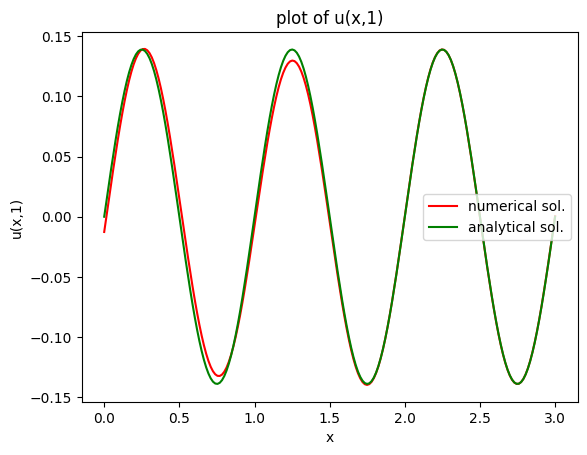

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator


def lax_wen(Nx, Nt, a, mu):
    """
    使用 Lax-Wendroff 方法解决偏微分方程

    参数：
        Nx (int): 空间方向上的网格数量
        Nt (int): 时间方向上的网格数量
        a (float): 传播速度
        mu (float): 粘性系数

    返回：
        u (np.array): 在空间和时间网格上的解
    """
    u = np.zeros((Nt, Nx))
    # 设置初始条件
    u[0, :] = np.sin(2*np.pi*np.linspace(0, 3, Nx))
    u[0, 0] = u[0, -2]
    u[0, 1] = u[0, -1]
    # 计算空间和时间步长
    dx = 3/(Nx-1)
    dt = 1/(Nt-1)
    # 计算 CFL 数
    c = a*dt/dx
    d = mu*dt/(dx**2)
    # 时间迭代
    for n in range(Nt-1):
        # 空间迭代
        for i in range(1, Nx-1):
            u[n+1, i] = u[n, i] - 0.5*c*(u[n, i+1] - u[n, i-1]) + \
                (d+c**2/2)*(u[n, i+1] - 2*u[n, i] + u[n, i-1])
        # 循环边界条件
        u[n+1, 0] = u[n+1, -2]
        u[n+1, -1] = u[n+1, 1]
    return u


def paint(u: np.array, name: str):
    """
    绘制二维数组的热图

    参数：
        u (np.array): 要绘制的二维数组
        name (str): 图像的标题
    """
    aspect_ratio = float(u.T.shape[1]) / u.T.shape[0]
    plt.imshow(u.T, cmap='viridis',
               interpolation='nearest', aspect=aspect_ratio)
    plt.colorbar()
    plt.title(name)
    plt.xlabel('Time')
    plt.ylabel('x')
    plt.xticks(np.linspace(0, u.shape[0]-1,
               num=5), np.linspace(0.0, 1.0, num=5))
    plt.yticks(np.linspace(0, u.shape[1]-1,
               num=5), np.linspace(0.0, 3.0, num=5))
    plt.savefig("./HW4_fig/"+name.replace(" ", "_")+".png")
    plt.show()


def value(u, Nx, Nt):
    """
    创建用于插值的函数，方便计算误差

    参数：
        u (np.array): 二维数组
        Nx (int): 空间方向上的网格数量
        Nt (int): 时间方向上的网格数量

    返回：
        interp_func (RegularGridInterpolator): 用于插值的函数
    """
    grid_x = np.linspace(0, 3, Nx)
    grid_t = np.linspace(0, 1, Nt)
    interp_func = RegularGridInterpolator((grid_t, grid_x), u)
    return interp_func


def error(u, Nx, Nt, f):
    """
    计算数值解与解析解之间的误差

    参数：
        u (np.array): 数值解
        Nx (int): 空间方向上的网格数量
        Nt (int): 时间方向上的网格数量
        f (function): 解析解的函数

    返回：
        err (float): L2误差
    """
    err = []
    dx = 3.0/(Nx-1)
    for x in range(Nx):
        X = x*dx
        T = 1.0
        err.append((f([T, X])-u[-1, x])**2)
    return np.sqrt(sum(err)*dx)

# 解析解表达式


def analytical_solution(x, t, a, nu):
    return np.exp(-4 * np.pi**2 * nu * t)*np.sin(2*np.pi*(x-a*t))


def u_analytical(Nx, Nt, a, mu):
    u = np.zeros((Nt, Nx))
    for n in range(Nt-1):
        for i in range(Nx-1):
            X = i*3.0/(Nx-1)
            T = n*1.0/(Nt-1)
            u[n, i] = analytical_solution(X, T, a, mu)
    return u


# 设置网格数量
nx = 200
nt = 2000
# 使用高分辨率参数运行 Lax-Wendroff 方法
u_hd = lax_wen(nx, nt, 1, 0.05)
# 计算解析解
u_an = u_analytical(nx, nt, 1, 0.05)
paint(u_hd, "Lax-Wendroff method solution")
paint(u_an, "analytical solution")
x = np.linspace(0.0, 3.0, num=nx)
# 绘制 x=1 处的 u(x,1) 图像
plt.plot(x, u_hd[nt-1, :], "r-", label="numerical sol.")
plt.plot(x, analytical_solution(x, 1, 1, 0.05), "g-", label="analytical sol.")
plt.title('plot of u(x,1)')
plt.xlabel('x')
plt.ylabel('u(x,1)')
plt.legend()
plt.savefig("./HW4_fig/fig_ux1")
plt.show()
# 创建用于高分辨率结果的插值函数
f_hd = value(u_hd, nx, nt)

## Q2：
采用非常密的网格上所得到的结果作为精确解，再利用相对较粗的网格来验证解的精度阶数。

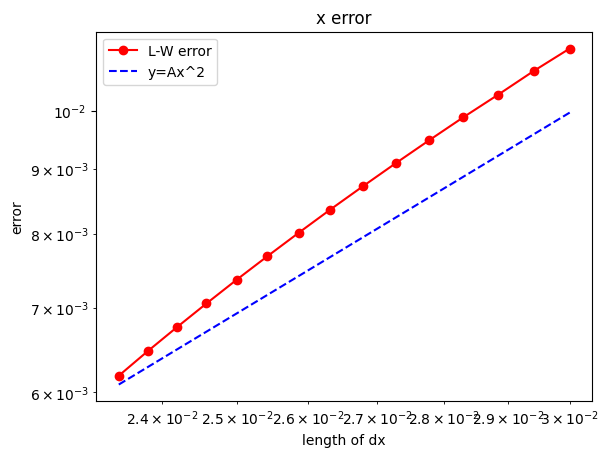

In [111]:
# 测试空间精度阶数
# 定义一系列不同的空间网格数量
x_list = list(range(100, 130, 2))
err_x = []
# 遍历不同的空间网格数量
for nnx in x_list:
    u = lax_wen(nnx, 2000, 1, 0.05)
    err_x.append(error(u, nnx, 2000, f_hd))
# 在双对数坐标轴上绘制误差随 dx 的变化图像
dx_list = np.array([3/i for i in x_list])
plt.loglog(dx_list, np.array(err_x), "-ro", label="L-W error")
# 绘制 y = Ax^2 的参考线
dx_reference = dx_list**2*np.exp(-2.2)
plt.loglog(dx_list, 100*dx_reference, "b--", label="y=Ax^2")
plt.title('x error')
plt.xlabel('length of dx')
plt.ylabel('error')
plt.legend()
plt.savefig("./HW4_fig/fig_dx")
plt.show()

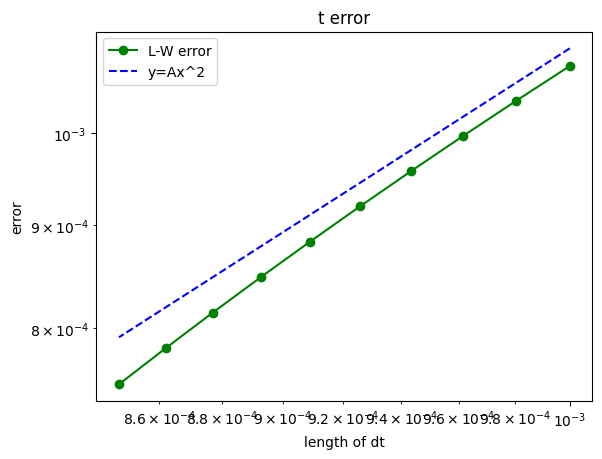

In [112]:
# 测试时间精度阶数
# 定义一系列不同的时间网格数量
t_list = list(range(1000, 1200, 20))
err_t = []
# 遍历不同的时间网格数量
for nnt in t_list:
    u = lax_wen(200, nnt, 1, 0.05)
    err_t.append(error(u, 200, nnt, f_hd))
dt_list = np.array([1/i for i in t_list])
# 在双对数坐标轴上绘制误差随 dt 的变化图像
plt.loglog(dt_list, np.array(err_t), "-go", label="L-W error")
# 绘制 y = Ax^2 的参考线
dt_reference = dt_list**2*np.exp(2.4)
plt.loglog(dt_list, 100*dt_reference, "b--", label="y=Ax^2")
plt.title('t error')
plt.xlabel('length of dt')
plt.ylabel('error')
plt.legend()
plt.savefig("./HW4_fig/fig_dt")
plt.show()

## Q3：
验证 $d=\frac{1-c^2}{6}$ 时的精度阶数有所提高。

[800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450]
[109, 113, 116, 119, 122, 125, 128, 131, 134, 137, 140, 142, 145, 147]


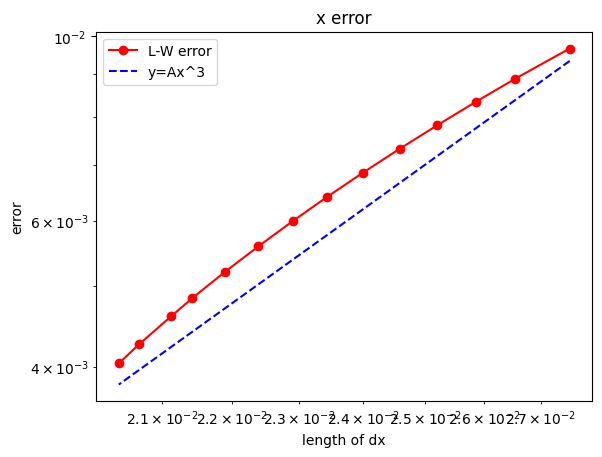

In [113]:
# 测试当 dx 和 dt 满足一定关系时，误差的精度阶数
# 定义一系列对应的不同的时间、空间网格数量，这里选取接近的整数
nt_list = list(range(800, 1500, 50))
nx_list = [round(np.sqrt(9*i**2/(1+0.6*i))) for i in nt_list]
print(nt_list)
print(nx_list)

err_x = []
# 遍历对应的(dx, dt)关系，观察误差随 dx 的变化
for i in range(len(nt_list)):
    nnx = nx_list[i]
    nnt = nt_list[i]
    u = lax_wen(nnx, nnt, 1, 0.05)
    err_x.append(error(u, nnx, nnt, f_hd))
dx_list = np.array([3/i for i in nx_list])
dt_list = np.array([1/i for i in nt_list])
# 绘制误差随 dx 的变化图像
plt.loglog(dx_list, np.array(err_x), "-ro", label="L-W error")
# 绘制 y = Ax^3 的参考线
dx_reference = dx_list**3*np.exp(1.5)
plt.loglog(dx_list, 100*dx_reference, "b--", label="y=Ax^3")
plt.title('x error')
plt.xlabel('length of dx')
plt.ylabel('error')
plt.legend()
plt.savefig("./HW4_fig/fig3")
plt.show()